<a href="https://colab.research.google.com/github/ErgoProxy1/Learning_AI/blob/main/makemore_language_model_tuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=PaCmpygFfXo&t=18s

In [1]:
words = open('names.txt', 'r').read().splitlines()

In [7]:
print("length",len(words))
print("min", min(len(word) for word in words))
print("max", max(len(word) for word in words))

length 32033
min 2
max 15


We want to create a character level generative language model. The goal is to be able to predict the next character given the previous sequence of characters before it.

For example "isabella" tells us that 'i' is likely to come first, that 's' is likely to come after 'i', that 'a' is likely to come after 'is', etc. (Also that given 'isabella', the word is likely to end)

There are many different types of language models:
- Bigram
- Bag of words
- MLP
- RNN
- GRU
- Transformer (GPT)



# Part 1: Bigram

Very simple model, we always work with two chars at a time (Given x, what's likely after y)

In [17]:
for w in words[:3]:
  for ch1, ch2 in zip(w, w[1:]): # Remember zip favors the shortest string, so for example emma is tuples between emma and mma
    print(ch1, ch2)

e m
m m
m a
o l
l i
i v
v i
i a
a v
v a


In [21]:
# Lets modify this a little to add a start and end indicator
b = {}
for w in words[:3]:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]): # Remember zip favors the shortest string, so for example emma is tuples between emma and mma
    print(ch1, ch2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


In [47]:
# Now let's track our bigrams

bigrams = {} # To keep a count of how often each bigram (pair of chars) occurs
for w in words: # ALL THE WORDS
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]): # Remember zip favors the shortest string, so for example emma is tuples between emma and mma
    b = (ch1, ch2)
    bigrams[b] = bigrams.get(b, 0) + 1
# sorted(bigrams.items(), key = lambda kv: kv[1], reverse = True)

In [35]:
# We have a nice dictionary that tells us about the frequency of pairs, but for machine learning purposes, lets use pytorch tensors
import torch

In [36]:
# Quick examples of tensors
a = torch.zeros((3 , 5))
print(a)
print(a.dtype) #float32 by default
print(a.shape)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
torch.float32
torch.Size([3, 5])


In [37]:
b = torch.zeros((3 , 5), dtype = torch.int32)
print(b)
print(b.dtype)

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)
torch.int32


In [42]:
# If we want to change the value at the first row in the 4th column (0 indexed ofc)
b[1 , 3] = 10
print(b)
b[1, 3] += 1
print(b)

tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0, 10,  0],
        [ 0,  0,  0,  0,  0]], dtype=torch.int32)
tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0, 11,  0],
        [ 0,  0,  0,  0,  0]], dtype=torch.int32)


So let's do it for our dataset. Remember we have a vocabulary size og 26+2 (letters of the alphabet plus our special chars \<S\> and \<E\>). So we'll need a tensor of 28x28 to represent each bigram (row would be the first char, column the second, and the value the frequency)

In [48]:
N = torch.zeros((28, 28), dtype = torch.int32)
lookup_table = {s:i+1 for i, s in enumerate(sorted(list(set(''.join(words)))))} #Put all the words into a string, use set to remove all dups (so its just the alphabet), sort it, then create a dictionary that maps each letter to a number
lookup_table['<S>'] = 26

for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
      ix1 = lookup_table[ch1] #index of first char
      ix2 = lookup_table[ch2] #index of second char
      N[ix1, ix2] += 1 # Keep count of occurences

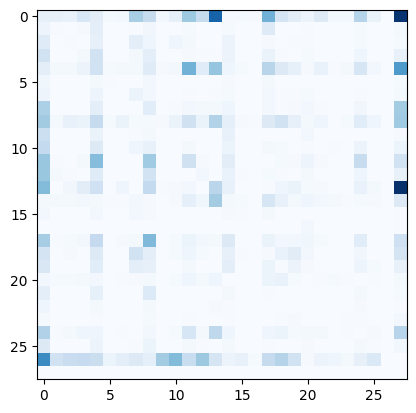

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(N, cmap = 'Blues') # Just to show the tensor in a nicer way, he does it well in the video but Im going to skip it for now
# However we can notice that the last row is completely empty as that represents the <E> char which will never not be at the end. Similar for the <S> and the second-to-last column.

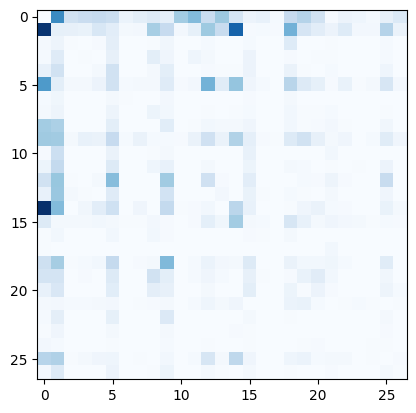

In [92]:
# Let's do it a bit more smartly to avoid empty columns and rows
N = torch.zeros((27, 27), dtype = torch.int32) # One less column and row

lookup_table = {s:i+1 for i, s in enumerate(sorted(list(set(''.join(words)))))} #offset by 1
lookup_table['.'] = 0 # Set just a . as the first row and column. We don't need two characters as we can know logically when a word starts and ends.

reverse_lookup = {i:s for s, i in lookup_table.items()}

for w in words:
  chs = ['.'] + list(w) + ['.'] # Just dots on both sides
  for ch1, ch2 in zip(chs, chs[1:]):
      ix1 = lookup_table[ch1] #index of first char
      ix2 = lookup_table[ch2] #index of second char
      N[ix1, ix2] += 1 # Keep count of occurences

plt.imshow(N, cmap = 'Blues') # Thats a bit better

We now have all the data we need neatly organized into a Tensor. Now we just need to follow these frequencies and start sampling.

In [93]:
N[0, :] #For example, this tells us how often each letter appears at the start (a 4410 times, b 1306 times, etc)

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [108]:
# lets now create our probability vector
probs = N[0].float() # Convert to tensor
probs = probs / probs.sum() # Normalize by dividing each occurence by the total occurences
probs # And the total sum would be 1 since this is just a list of probabilities

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [95]:
g = torch.Generator().manual_seed(2147483647) # Allows us to define a generator for randomness control. We're using the same seed as the video here.
probs_example = torch.rand(3, generator = g)
probs_example = probs_example / probs_example.sum()
probs_example # Confirming we're getting the same data every time

tensor([0.6064, 0.3033, 0.0903])

In [96]:
# https://pytorch.org/docs/stable/generated/torch.multinomial.html
torch.multinomial(probs_example, num_samples = 30, replacement = True, generator = g) # We're going to sample based off the normalized probabilities vector. Replacement says we can pull the same sample more than once
# In theory, 2 should appear less frequently than 1 and 1 less than 0, since 0 has a 60% chance, 30% for 1, and 10% for 2.

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0])

We can apply multinomial sampling in chain to create words!

In [115]:
# Here's a single iteration
g = torch.Generator().manual_seed(2147483647)
i1 = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item() # First index sample
print(reverse_lookup[i1]) # Gives us the letter

probs2 = N[i1].float() # Get the matching row of i1
probs2 = probs2 / probs2.sum() # Normalize

i2 = torch.multinomial(probs2, num_samples = 1, replacement = True, generator = g).item() # Second index sample
print(reverse_lookup[i2]) # So this tells us what letter comes after the first one

j
u


In [151]:
# So let's just do it
g = torch.Generator().manual_seed(2147483647)

Probabilities = (N+1).float() #Add 1 for model smoothing, we dont want 0 divisions
# Always make sure to check broadcasting semantics https://pytorch.org/docs/stable/notes/broadcasting.html
# Since ours is 27x27 and 27x1, we're all good
Probabilities /= Probabilities.sum(1, keepdim=True) # Specify we want the sum with respect to the second dimension (columns) and to keep the dimensions (27x1 tensor, not 27 item list)

for i in range(10):
  out = []
  ix = 0
  while True:
    p = Probabilities[ix]
    ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
    out.append(ix)
    if ix == 0:
      break
  print(''.join(reverse_lookup[i] for i in out)) #Its terrible, but that's normal. It doesn't have any context beyond the current letter. Explains why sometimes it just generates a single letter, because it doesn't know that single letter was at the start.

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


While what it generates isn't great, it's much better than what a completely uniform distribution would give
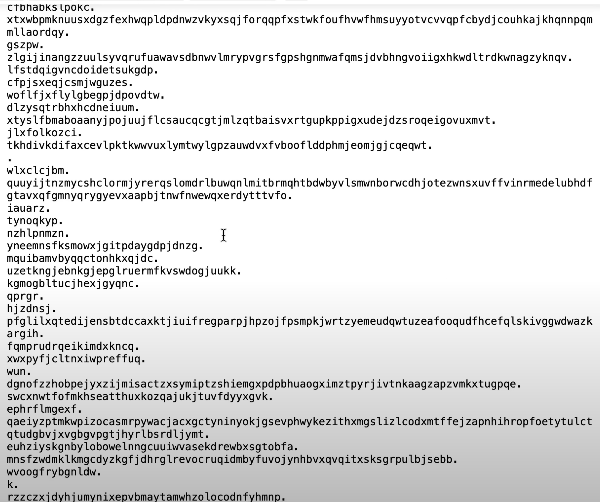

Also remember to respect the broadcasting semantics when manipulating tensors https://pytorch.org/docs/stable/notes/broadcasting.html

For example if we had not put keepdim in our Probabilities sum calculation, we would have had a tensor of shape [27] rather than [27,1] (a column vector). What  this would have a done internally is rather than compare:

> 27 x 27

> 27 x 1

Which is valid, we would have had (because shift to the right):

> 27 x 27

> _ x 27

Which would evaluate to

> 27 x 27

> 1 x 27

Which is not the same at all and would have resulted in a bug. Instead of multiplying a tensor by a column vector, we would have had a row vector! Our column probabilities would have sum to 1, but we want our rows to sum to 1 (Since the rows represent our actual combinations for a given first letter (ja, jb, jc, etc)).

Okay now let's calculate our loss to evaluate the quality of our model. We're going to use the negative log likelihood from maximum likelihood estimation (maximum de vraisemblance).

In [153]:
for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = lookup_table[ch1]
    ix2 = lookup_table[ch2]
    prob = Probabilities[ix1, ix2]
    print(f'{ch1}{ch2}: {prob:.4f}')
# We can check the probabilities of each pairing. We can tell our Bigram model learned SOMETHING, since some probabilities are much different from 1/27=0.04

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3885
a.: 0.1958
.o: 0.0123
ol: 0.0779
li: 0.1774
iv: 0.0152
vi: 0.3508
ia: 0.1380
a.: 0.1958
.a: 0.1376
av: 0.0246
va: 0.2473
a.: 0.1958


In [156]:
# Now lets add in the log prob. The closer to 0 the better, since that means we're close to a high probability (1). But the numbers tend to dip down quckly as the probability goes down.
# Using log works well because log(a*b*c) = log(a) + log(b) + log(c), which make probability products easier to work with.
log_likelihood = 0.0
n = 0
for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = lookup_table[ch1]
    ix2 = lookup_table[ch2]
    prob = Probabilities[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print("likelihood", log_likelihood)
negative_log_likelihood = -log_likelihood
print("negative log likelihood", negative_log_likelihood)
print("average negative log likelihood (probably what we would use as the loss function)", negative_log_likelihood/n)

.e: 0.0478 -3.0410
em: 0.0377 -3.2793
mm: 0.0253 -3.6753
ma: 0.3885 -0.9454
a.: 0.1958 -1.6305
.o: 0.0123 -4.3965
ol: 0.0779 -2.5526
li: 0.1774 -1.7293
iv: 0.0152 -4.1845
vi: 0.3508 -1.0476
ia: 0.1380 -1.9807
a.: 0.1958 -1.6305
.a: 0.1376 -1.9835
av: 0.0246 -3.7041
va: 0.2473 -1.3971
a.: 0.1958 -1.6305
likelihood tensor(-38.8086)
negative log likelihood tensor(38.8086)
average negative log likelihood (probably what we would use as the loss function) tensor(2.4255)


So our model needs to minimize the average negative log likelihood loss.

Our goal is to maximize the likelihood of the data with respect to our parameters, aka maximimize log likelihood, aka minimize negative log likelihood, aka minimize average negative log likelihood

# Part 2 Neural Net